In [1]:
import sys
sys.path.append('../Scripts')
from capstone_functions import *

In [2]:
from collections import defaultdict

import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.spatial.distance import euclidean

import matplotlib.pyplot as plt
import seaborn as sns

import contextily as ctx
import imageio
import os

sns.set(style="white")
colorblind_palette = sns.color_palette('colorblind').as_hex()

%matplotlib inline

In [124]:
# source : https://blog.jsalv.com/pythonin-voronoi-and-k-means/

# functions to run through k_means algorithm and plot the voronoi

def classify_points(centers, data):
    """Classifies points from data according to which center they're closest to.
       Returns points like {'g': np.array([..., ...], ...), }
    """
    classes = defaultdict(list)
    for pt in data:             
        dists = [euclidean(pt, center) for center in centers]
        classes[colorblind_palette[dists.index(min(dists))]].append(pt)

    # Concat the list of points in each class together to a np array.
    classes = {cl: np.array(classes[cl]) for cl in classes.keys()}
    return classes

def find_new_medians(data_classified):
    '''Calculates new centers using median of points in the classified data.'''
    new_medians = []
    for pts in data_classified.values():
        new_medians.append(np.median(pts, axis=0))
    return np.array(new_medians)

def find_new_centers(data_classified):
    '''Calculates new centers using mean of points in the classified data.'''
    new_means = []
    for pts in data_classified.values():
        new_means.append(pts.mean(axis=0))
    return np.array(new_means)

def plot_voronoi(iteration, centroids, data_classified, save_on=False):
    fig, ax = plt.subplots(figsize=(15, 15))
    """Plot the Voronoi diagram with our data classified."""
    ax.set_title(f"Iteration {iteration}", fontsize=20)
    vor = Voronoi(centroids)
    _ = voronoi_plot_2d(vor, ax=ax, show_points=False, show_vertices=False, line_width=3)
    for center in data_classified.keys():
        ax.scatter(
            data_classified[center][:, 0], data_classified[center][:, 1], c=center, s=15, alpha=0.8 )
    ax.scatter(centroids[:, 0], centroids[:, 1], c="black", s=90, marker="P")
    ax.axis('off')
    ax.set_xlim(x_lims)
    ax.set_ylim(y_lims)
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
    # save the chart of the iterations
    if save_on:
        plt.savefig('../Images/'+f'k_means_iter{i:03}.png')
    
def create_gif(images_path='../Images', output_file=f'../Outputs/k_means.gif', fps=3):
    files = os.listdir(images_path)
    files.sort()
    images_path_filename = [os.path.join(images_path,file) for file in files]
    images = []
    for img in images_path_filename:
        images.append(imageio.imread(img))
    imageio.mimsave(output_file, images, fps=fps)
    !rm ../Images/*.*
    print('gif created')

In [126]:
# Create individual plots of k_means iterations for making a gif
def visualise_k_means(method='k_means', remove_outlier=True, n_iter=15, gif=False, output_filename='k_means_viz'):
    train_df = create_crash_df('../Inputs/Train.csv')
    if remove_outlier:
        train_df = outlier_removal(train_df, filter=0.005)

    # convert coordinate system
    k = 6378137
    train_df['longitude'] = train_df['longitude'].apply(lambda x: x * (k * np.pi/180.0))
    train_df['latitude'] = train_df['latitude'].apply(lambda x: np.log(np.tan((90 + x) * np.pi/360.0)) * k)
    data = train_df[['longitude','latitude']].values

    # set up initial centroids
    n_centers = 6
    centroids = np.random.rand(n_centers, 2) * k / 360
    centroids = centroids + (train_df.longitude.median(), train_df.latitude.median())
    # Make some nice boundaries
    #lat_min = train_df.latitude.min()
    #lat_max = train_df.latitude.max()
    #lon_min = train_df.longitude.min()
    #lon_max = train_df.longitude.max()
    #y_lims = ((lat_min-lat_max), (lat_max+lat_max*-0.4))
    #x_lims = ((lon_min-lon_min*0.001), (lon_max-lon_min*0.001))
    # hard coding optimal
    y_lims = (-276743.5935774802, -37764.79152683686)
    x_lims = (4040437.699748081, 4212681.056255888)

    # run through iterations of k_means
    for i in range(n_iter):
        # Assign points to centroids
        data_classified = classify_points(centers=centroids, data=data)
        # Plot the Voronoi diagram with our data classified
        plot_voronoi(i, centroids, data_classified, save_on=gif)
        # Update the centroids based on points
        if method == 'k_means':
            centroids = find_new_centers(data_classified)
        elif method == 'k_medians':
            centroids = find_new_medians(data_classified)
    if gif:
        create_gif(output_file=f'{output_filename}_{dt.datetime.now()}.gif')


0
1


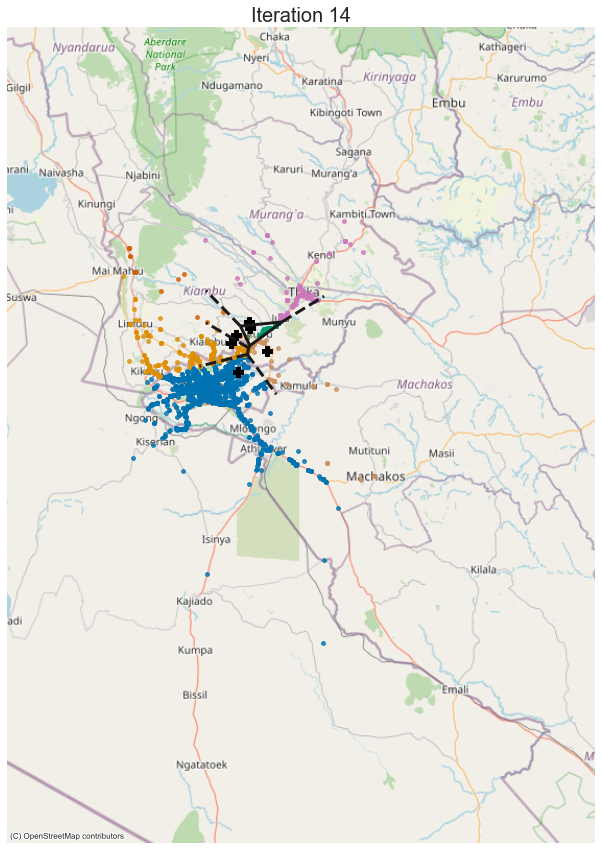

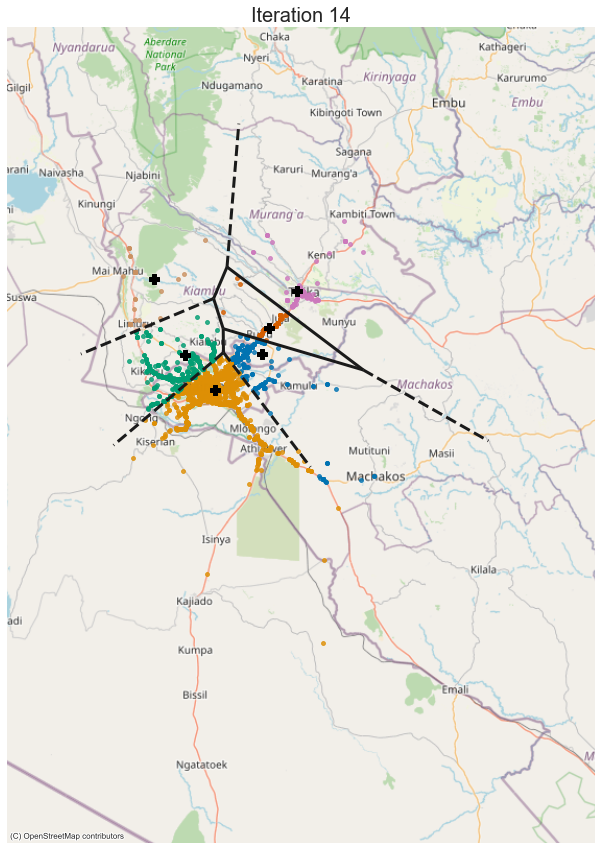

In [127]:
visualise_k_means(method='k_means', remove_outlier=True, n_iter=2, gif=False)